# Computer Vision Project - Identifying Faces from Movie Stills  

---



**Problem Statement**

Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company  wants  to  automate  the  process  of  cast  and  crew  information  in  each  scene  from  a  movie  such  that  when  a  user  pauses  on  the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

**Data for Project**
The dataset comprises of images and its mask where there is a human face


Importing Essential Libraries 

In [140]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [141]:
print(tf.__version__)

2.4.1


Connecting to Google Drive ( Mounting ) 

In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing essential Libraries 

In [143]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
#Installing Tensorboard for Colab
!pip install tensorboardcolab

Loading The Data 

In [144]:
import numpy as np
from PIL import Image

img_array = np.load('/content/drive/MyDrive/Part 1- Train data - images.npy',allow_pickle=True)

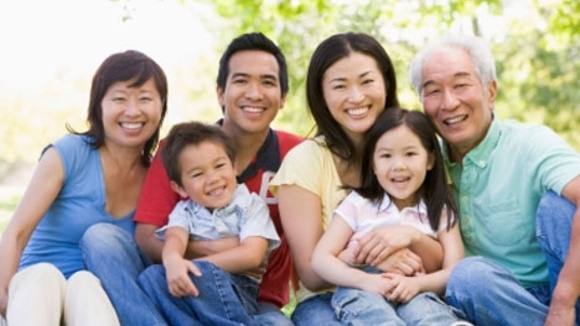

In [145]:
image2 = Image.fromarray(img_array[4][0]) # Checking one of the images
image2

Checking the bounding box for the faces in the image

In [146]:
import numpy as np
import cv2

opencvImage = cv2.cvtColor(np.array(image2), cv2.COLOR_RGB2BGR)
for num in range(0,len(img_array[4][1])):
  start_point = (int(img_array[4][1][num]["points"][0]["x"]*int(img_array[4][1][num]["imageWidth"])),int(img_array[4][1][num]["points"][0]["y"]*int(img_array[4][1][num]["imageHeight"])))
  end_point = (int(img_array[4][1][num]["points"][1]["x"]*int(img_array[4][1][num]["imageWidth"])),int(img_array[4][1][num]["points"][1]["y"]*int(img_array[4][1][num]["imageHeight"])))
  image9 = cv2.rectangle(opencvImage,start_point,end_point,(0,0,255),2)

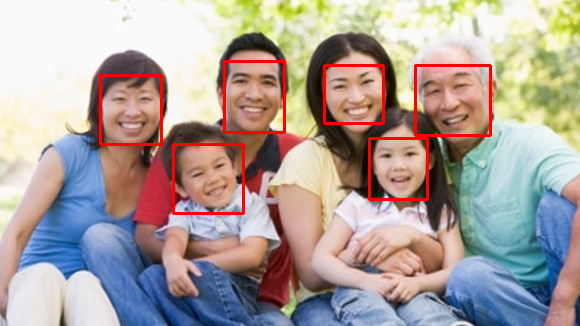

In [147]:
from google.colab.patches import cv2_imshow
cv2_imshow(image9)

Isolating the label and the training data

In [148]:
img = []
label = []
for still in range(0,len(img_array)):
  img.append(img_array[still][0])
  label.append(img_array[still][1])

In [186]:
img_array[0][0].shape

(333, 650, 3)

In [149]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

image_height = 256
image_width = 256

X_train = []

for i in range(0,len(img)):
  img_temp = Image.fromarray(img_array[i][0])
  img_temp = img_temp.resize((image_height,image_width))
  img_temp = img_temp.convert('RGB')
  X_train.append(preprocess_input(np.array(img_temp, dtype=np.float32))) # Convert to float32 array
  img_temp.close()

In [150]:
X_train = np.array(X_train)

In [151]:
X_train.shape

(409, 256, 256, 3)

Transforming the coordinates to a matrix

In [152]:
masks = np.zeros((int(img_array.shape[0]), image_height, image_width))
for s in range(0,len(label)):
  for i in img_array[s][1]:
        x1 = int(i["points"][0]['x'] * image_width)
        x2 = int(i["points"][1]['x'] * image_width)
        y1 = int(i["points"][0]['y'] * image_height)
        y2 = int(i["points"][1]['y'] * image_height)
        masks[s][y1:y2, x1:x2] = 1

In [153]:
masks.shape # Checking the shape

(409, 256, 256)

Checking the mask sharpe for a random image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


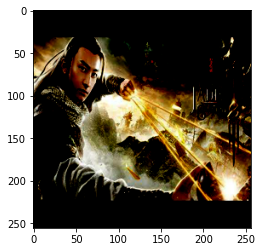

In [154]:
import matplotlib.pyplot as plt
n = 21
plt.imshow(X_train[n])

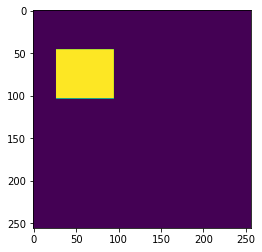

In [155]:
plt.imshow(masks[n])

Train Test Split

In [156]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, masks, test_size=0.1, random_state=42)

Model Development

In [157]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [158]:


def create_model(trainable = True):
    IMG_SHAPE = (256, 256, 3)
    model = MobileNet(input_shape = IMG_SHAPE, alpha = 1.0, include_top = False, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer('conv_pw_1_relu').output
    block1 = model.get_layer('conv_pw_3_relu').output
    block2 = model.get_layer('conv_pw_5_relu').output
    block3 = model.get_layer('conv_pw_11_relu').output
    block4 = model.get_layer('conv_pw_13_relu').output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size = 1, activation = "sigmoid")(x)

    x = Reshape((256, 256))(x)

    return Model(inputs = model.input, outputs = x)



In [159]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 128, 128, 32) 0           conv1_bn[0][0]                   
____________________________________________________________________________________________

In [160]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [161]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [162]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [163]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [164]:
model.fit(X_train, y_train, epochs = 20, batch_size = 1, validation_split = 0.1,  #splitting 10% of data into validation set          
                    callbacks = [checkpoint, reduce_lr, stop],
                    workers = 8,
                    use_multiprocessing = True,                    
                    verbose = 1,validation_data=(X_valid, y_valid))

Streaming output truncated to the last 5000 lines.
Epoch 00013: loss did not improve from 0.26900
157/331 [=============>................] - ETA: 4:05 - loss: 0.3373 - dice_coefficient: 0.7974
Epoch 00013: loss did not improve from 0.26900
158/331 [=============>................] - ETA: 4:04 - loss: 0.3372 - dice_coefficient: 0.7974
Epoch 00013: loss did not improve from 0.26900
159/331 [=============>................] - ETA: 4:03 - loss: 0.3372 - dice_coefficient: 0.7974
Epoch 00013: loss did not improve from 0.26900
160/331 [=============>................] - ETA: 4:01 - loss: 0.3371 - dice_coefficient: 0.7974
Epoch 00013: loss did not improve from 0.26900
161/331 [=============>................] - ETA: 4:00 - loss: 0.3371 - dice_coefficient: 0.7974
Epoch 00013: loss did not improve from 0.26900
162/331 [=============>................] - ETA: 3:58 - loss: 0.3370 - dice_coefficient: 0.7974
Epoch 00013: loss did not improve from 0.26900
163/331 [=============>................] - ETA: 3:

In [179]:
model.load_weights('model-0.27.h5') # Loading the most effective model weights

Testing the output with a random image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


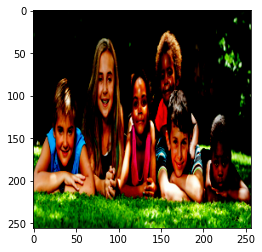

In [180]:
n = 5
sample_image = X_train[n]
final_image = sample_image
print(sample_image.shape)
plt.imshow(sample_image)

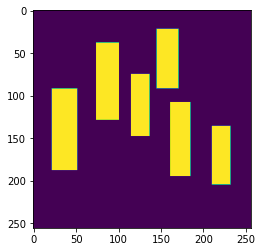

In [181]:
n = 5
sample_mask = y_train[n]
final_mask = sample_mask
plt.imshow(sample_mask)

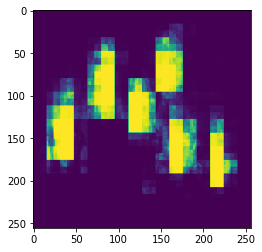

In [182]:
sample_image = np.resize(sample_image, (1, 256, 256, 3))
pred_mask = model.predict(x = sample_image)
pred_mask = np.resize(pred_mask, (256, 256))
plt.imshow(pred_mask)

Observation


*   The areas identified by the model is accurate to the actual face mask area 
*   This is only in the training data, but need to validate with the test image



Locating Prediction Image

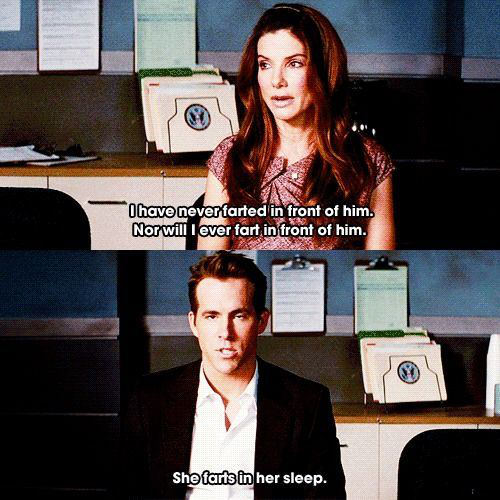

In [183]:
from PIL import Image

image = Image.open('/content/drive/MyDrive/Part 1Test Data - Prediction Image.jpeg')
 
image

In [188]:
from numpy import asarray # Transforming the image into a format that can be used for prediction 

data = asarray(image)

In [190]:
img_temp = Image.fromarray(data)
img_temp = img_temp.resize((256,256))
img_temp = img_temp.convert('RGB')
img_temp = preprocess_input(np.array(img_temp, dtype=np.float32)) # Convert to float32 array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


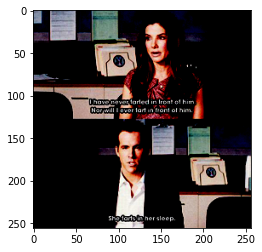

In [192]:

sample_image = img_temp
final_image = sample_image
print(sample_image.shape)
plt.imshow(sample_image)

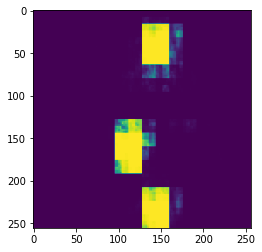

In [194]:
sample_image = np.resize(sample_image, (1, 256, 256, 3))
pred_mask = model.predict(x = sample_image)
pred_mask = np.resize(pred_mask, (256, 256))
plt.imshow(pred_mask)

Observation


*   The predicted area for the face seems accurate 
*   The model has detected a face in the bottom that is actually inaccurate 



Testing with a random image off the internet

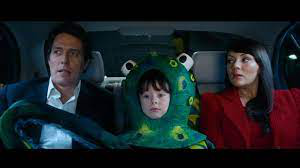

In [195]:
image = Image.open('/content/drive/MyDrive/pred image.jpg')
 
image

In [196]:
from numpy import asarray

data = asarray(image)

In [197]:
img_temp = Image.fromarray(data)
img_temp = img_temp.resize((256,256))
img_temp = img_temp.convert('RGB')
img_temp = preprocess_input(np.array(img_temp, dtype=np.float32)) # Convert to float32 array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


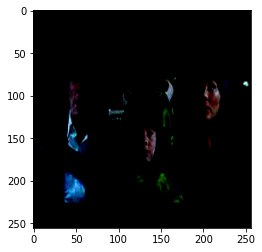

In [198]:
sample_image = img_temp
final_image = sample_image
print(sample_image.shape)
plt.imshow(sample_image)

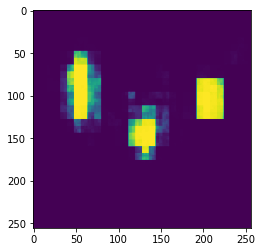

In [199]:
sample_image = np.resize(sample_image, (1, 256, 256, 3))
pred_mask = model.predict(x = sample_image)
pred_mask = np.resize(pred_mask, (256, 256))
plt.imshow(pred_mask)

Observation


*   The model Prediction seems accurate



**Conclusion**

*   Based on the problem statement, a model was developed to identify the face area for any given image
*   This model can be used to identify the faces, when a user pauses a movie
*   To solve the full problem statement, further models are needed to identify the actors and share the details - but thats not part of the scope of this task
*   Learnings 
- data was loaded 
- data was preprocessed 
- model was developed 
- The metrics needed for model evaluation were defined and used
- model predictions were tested and found to be satisfactory 



